# 「プチ」勉強会 20230902
* 今回は、実践課題「心臓病の予測をしよう」の探索。
* 比較的簡単な二値分類問題だが、テーマが心臓病だけにドメイン知識がものを言う課題。
* そういう意味ではEDAでこれといった新しい切り口は見出せなかった。
* その分、今回はChatGPTくんに手伝ってもらってモデルのブラッシュアップ手法をいろいろ試した。<br>
前回、活躍した学習曲線は今回も大活躍。<br>
ほか、NNモデルとのアンサンブルを試し、これがうまくいった。


## 今回取り組んでみたこと
1. 新しい手法やコーディングスタイルを学ぶべくChatGPTをフル活用した。<br>
いろいろ議論のあるChatGPT活用だが、学習効果が著しく高いと実感している。使わない手はない。
```
   ・応用課題でNNモデルの基本形を学んだが、今回はそこから合成特徴量を抽出してLogistic回帰モデルとアンサンブルする手法を試した。
   ・NNモデルは過学習し易いと言われているが、今回も先週作った学習曲線による過学習モニタリングが大活躍した。
   ・その他、特徴量選択の補助ツールとして「部分依存プロット（PDP）」や「SHAP」の要約プロットを活用した。
   　こういった様々なツール類の学習にはChatGPTの助言と助力が非常に有効。
     取り敢えず基本形を実装してもらい、自分で手直ししたり、別の課題に応用したりするうちに使い方が板についてくる。
```
2. 一旦、自力でサブミットまで行ったあと改めてChatGPTにデータを渡してモデル作成を指示、最終形までコーディングしてもらった。
```
   ・特徴量作成のポイントなど具体的に指示しており結果に大差はないが、コーディングスタイルが自分のやり方と異なり斬新だった。
   ・アンサンブルの結果、提出スコアも初回サブミットの0.96から0.97まで改善させることができた。
   ・NNモデルのアンサンブルは、特徴量を増やすと見た目もっと改善するが提出スコアに反映されにくい。つまり過学習している。
   ・上記の各種ツールで丁寧に処理していくことで実質的なモデルの改善が実現する。
```

# 心臓病の予測をしよう

In [1]:

# ライブラリのインポート
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.linear_model import LogisticRegression
from sklearn import tree
from sklearn import ensemble
from sklearn import svm
import lightgbm as lgb

from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import roc_auc_score, roc_curve, auc, confusion_matrix, accuracy_score
from sklearn.preprocessing import StandardScaler

import warnings
warnings.simplefilter('ignore')

sns.set(style='white')
import japanize_matplotlib

# 表示桁数の設定
%precision 3
pd.options.display.precision = 3

In [2]:
# 訓練用データ
df = pd.read_csv('C:\\Users\\yuich\\KC_data\\heart_disease\\train.csv')
# 提出用データ
df_test = pd.read_csv('C:\\Users\\yuich\\KC_data\\heart_disease\\test.csv')

## データ概観

In [3]:
# 訓練データ
display(df.info())
display(df.head())
display(df.describe())
display(df.describe(include='object'))

# 提出用データ
display(df_test.info())
display(df_test.head())
display(df_test.describe())
display(df_test.describe(include='object'))

# 欠損値                     ： train   test
# RestingBP                  :    1      0
# MaxHR                      :  426     47


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 826 entries, 0 to 825
Data columns (total 13 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   ID              826 non-null    int64  
 1   Age             826 non-null    int64  
 2   Sex             826 non-null    object 
 3   ChestPainType   826 non-null    object 
 4   RestingBP       825 non-null    float64
 5   Cholesterol     826 non-null    int64  
 6   FastingBS       826 non-null    int64  
 7   RestingECG      826 non-null    object 
 8   ExerciseAngina  826 non-null    object 
 9   Oldpeak         826 non-null    float64
 10  ST_Slope        826 non-null    object 
 11  HeartDisease    826 non-null    int64  
 12  MaxHR           426 non-null    float64
dtypes: float64(3), int64(5), object(5)
memory usage: 84.0+ KB


None

,ID,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease,MaxHR
0,645,57,M,NAP,128.0,229,0,LVH,N,0.4,Flat,1,NaN
1,664,65,F,ASY,150.0,225,0,LVH,N,1.0,Flat,1,NaN
2,573,72,M,ASY,160.0,123,1,LVH,N,1.5,Flat,1,NaN
3,609,46,M,ASY,134.0,310,0,Normal,N,0.0,Flat,1,NaN
4,694,56,M,ATA,120.0,236,0,Normal,N,0.8,Up,0,178.0


,ID,Age,RestingBP,Cholesterol,FastingBS,Oldpeak,HeartDisease,MaxHR
count,826.000,826.000,825.000,826.000,826.000,826.000,826.000,426.000
mean,463.222,53.703,132.384,200.007,0.238,0.890,0.553,143.829
std,265.962,9.482,17.909,108.835,0.426,1.075,0.497,24.510
min,0.000,28.000,80.000,0.000,0.000,-2.600,0.000,69.000
25%,232.250,47.000,120.000,175.250,0.000,0.000,0.000,127.000
50%,468.500,54.000,130.000,223.000,0.000,0.600,1.000,144.000
75%,690.750,60.000,140.000,267.000,0.000,1.500,1.000,162.750
max,917.000,77.000,200.000,603.000,1.000,6.200,1.000,202.000


,Sex,ChestPainType,RestingECG,ExerciseAngina,ST_Slope
count,826,826,826,826,826
unique,2,4,3,2,3
top,M,ASY,Normal,N,Flat
freq,649,442,493,494,411


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 92 entries, 0 to 91
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   ID              92 non-null     int64  
 1   Age             92 non-null     int64  
 2   Sex             92 non-null     object 
 3   ChestPainType   92 non-null     object 
 4   RestingBP       92 non-null     float64
 5   Cholesterol     92 non-null     int64  
 6   FastingBS       92 non-null     int64  
 7   RestingECG      92 non-null     object 
 8   ExerciseAngina  92 non-null     object 
 9   Oldpeak         92 non-null     float64
 10  ST_Slope        92 non-null     object 
 11  MaxHR           45 non-null     float64
dtypes: float64(3), int64(4), object(5)
memory usage: 8.8+ KB


None

,ID,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,ExerciseAngina,Oldpeak,ST_Slope,MaxHR
0,802,52,M,ASY,108.0,233,1,Normal,N,0.1,Up,NaN
1,800,43,M,NAP,130.0,315,0,Normal,N,1.9,Up,162.0
2,289,36,M,ATA,120.0,166,0,Normal,N,0.0,Up,180.0
3,776,62,F,ASY,150.0,244,0,Normal,Y,1.4,Flat,NaN
4,592,61,M,ASY,190.0,287,1,LVH,Y,2.0,Down,NaN


,ID,Age,RestingBP,Cholesterol,FastingBS,Oldpeak,MaxHR
count,92.000,92.000,92.000,92.000,92.000,92.000,45.000
mean,416.109,51.783,133.946,187.957,0.185,0.866,142.111
std,255.217,8.841,18.834,114.236,0.390,0.995,22.544
min,8.000,34.000,94.000,0.000,0.000,-0.800,84.000
25%,215.500,44.750,120.000,130.750,0.000,0.000,126.000
50%,375.000,52.000,130.000,220.500,0.000,0.550,144.000
75%,632.500,59.000,145.000,266.000,0.000,1.500,160.000
max,903.000,69.000,200.000,412.000,1.000,4.200,188.000


,Sex,ChestPainType,RestingECG,ExerciseAngina,ST_Slope
count,92,92,92,92,92
unique,2,4,3,2,3
top,M,ASY,Normal,N,Flat
freq,76,54,59,53,49


## EDA（データ探索）

データセットのカラム説明
```
HeartDisease   : 目的変数 [1: 心臓病, 0: 正常]

Age            : 患者の年齢
Sex            : 患者の性別 (M: 男性 F: 女性)
ChestPainType  : 胸痛の種類 [TA: 典型的狭心症, ATA: 非典型狭心症, NAP: 非狭心症性疼痛、ASY：無症状]
RestingBP      : 安静時血圧
Cholesterol    : 血清コレステロール[mg/dl]値
FastingBS      : 空腹時血糖値 [1: FastingBS > 120 mg/dl, 0: それ以外の場合]
RestingECG     : 安静時心電図結果［Normal: ST：ST-T波異常（T波反転及び／又は0.05mV以上のST上昇又はST低下）を有する、
                                    LVH：エステスの基準による左室肥大の可能性又は確定を示す]
ExerciseAngina : 運動誘発性狭心症【Y：Yes, N：No】
Oldpeak        : 安静時と比較した運動時のST低下
ST_Slope       : 運動時STピークセグメントの傾き [Up: 上り勾配、Flat: 平坦、Down: 下り勾配]
MaxHR          : 最高心拍数 [60～202の数値]
```

各特徴量の一般的なガイドライン
```
Age:            高齢は心臓病のリスクが高まると一般的に認識されている
Sex:            男性の方が若い年齢で心臓病のリスクが高いとされているが、女性も特に閉経後にリスクが増加する
ChestPainType:  胸痛のタイプや持続時間、発生のトリガーなどによって心臓病のタイプや重症度が推定される
RestingBP:　    正常:         120/80 mmHg 以下
                予高血圧:     収縮期血圧 120-129 且つ 拡張期血圧 80 以下
                高血圧第1度:  収縮期血圧 130-139 または 拡張期血圧 80-89
                高血圧第2度:  収縮期血圧 140 以上 または 拡張期血圧 90 以上
                危機的高血圧: 収縮期血圧 180 以上 または 拡張期血圧 120 以上
Cholesterol:    良好:     200 mg/dL 以下
                境界領域: 200-239 mg/dL
                高値:     240 mg/dL 以上
FastingBS:      正常:       99 mg/dL 以下
                糖尿病前症: 100-125 mg/dL
                糖尿病:     126 mg/dL 以上
RestingECG:     異常な波形やリズムは心臓の異常を示すことがある
ExerciseAngina: 運動誘発性狭心症が認められる場合、冠動脈の狭窄や閉塞の可能性が高まる
Oldpeak:        1 mm以上のSTセグメントの低下は、冠動脈疾患の可能性を示唆することがある
ST_Slope:       STセグメントの傾きも、冠動脈疾患の診断に関与する
MaxHR:          年齢に応じた最大心拍数からの逸脱は、冠動脈疾患の指標として使用されることがある
```

各特徴量と心臓病の関係
```
Age：            高齢になると、動脈硬化や高血圧のリスクが高まるため、心臓病のリスクも高まるとされている
Sex：            性別によって、心臓病のリスクが異なることが知られており、特に中年以前の男性は、女性よりも冠動脈心臓病のリスクが高いとされている
ChestPainType：  狭心症は心臓病の典型的な症状の一つで、特に典型的狭心症は、冠動脈の狭窄や閉塞によるものであり、心臓病のリスクが高いと考えられる
RestingBP：      長期的な高血圧は、心臓や血管に負担をかけ、動脈硬化を進行させるリスクがあるため、心臓病のリスクが高まる
Cholesterol：    高コレステロールは、動脈硬化のリスクを高め、それにより心臓病のリスクが増加する可能性がある
FastingBS：      高血糖は動脈硬化を進行させるリスクがあるため、心臓病のリスクが高まる
RestingECG：     心電図の異常は、心臓の筋肉やリズムの問題を示す可能性がある
ExerciseAngina： 運動誘発性狭心症は、冠動脈の一部が狭窄または閉塞していることを示唆する可能性がある
Oldpeak：        運動後のSTセグメントの変動は、心筋の虚血を示唆する可能性がある
ST_Slope：       STセグメントの傾きの異常は、心筋の虚血や損傷を示唆する可能性がある
MaxHR：          運動時の最高心拍数は、心臓の健康状態や運動能力を反映する指標として考えられる
```

心臓病の種類
```
冠動脈心臓病 (CAD: Coronary Artery Disease)：
                冠動脈（心臓の筋肉に酸素を供給する動脈）が狭窄または閉塞することにより、心筋に十分な酸素が供給されない状態、動脈硬化が主な原因
心筋梗塞：       冠動脈の一部が急激に閉塞し、その結果、心筋の一部が酸欠となって壊死する状態
心不全：         心臓が体に十分な血液をポンプアップすることができない状態。心筋梗塞、高血圧、心筋炎などが原因で発症することが多い
心房細動：       心臓の上部、特に心房が非常に高速かつ不規則に動く状態。これにより、心臓が血液を効果的にポンプアップすることが困難となる
心筋炎：         心筋が炎症を起こす状態。ウイルス感染が原因となることが多い
弁膜症：         心臓の弁が正常に開閉しない、または漏れる状態、先天性のものやリウマチ熱、感染症によって後天的に発症することもある
先天性心疾患：   生まれつきの心の異常。心室中隔欠損症や大血管転位などが含まれる
心臓の腫瘍：     心臓に発生する良性または悪性の腫瘍。非常にまれ
心嚢炎：         心臓を取り巻く薄い袋状の組織（心嚢）が炎症を起こす状態
```

## EDA(データ探索)

,HeartDisease
HeartDisease,
0,369
1,457


罹患率は、 55.33%


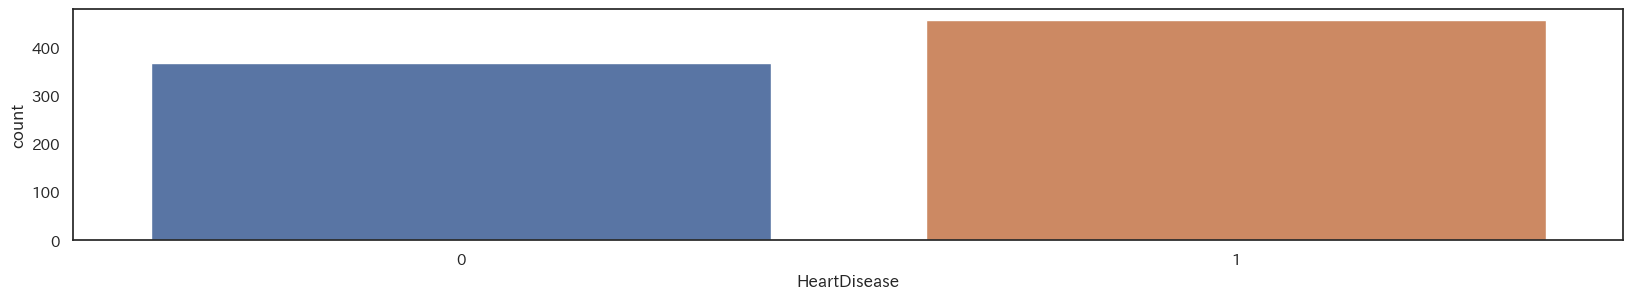

In [4]:
# HeartDisease(目的変数)

fig, ax = plt.subplots(figsize=(20, 3))
sns.countplot(data=df, x='HeartDisease', ax=ax)

display(df.groupby('HeartDisease')[['HeartDisease']].count())
print(f'罹患率は、{457/(457+369): 0.2%}')

# 陽性率55.33%で比較的均衡している

<Axes: xlabel='Age', ylabel='HeartDisease'>

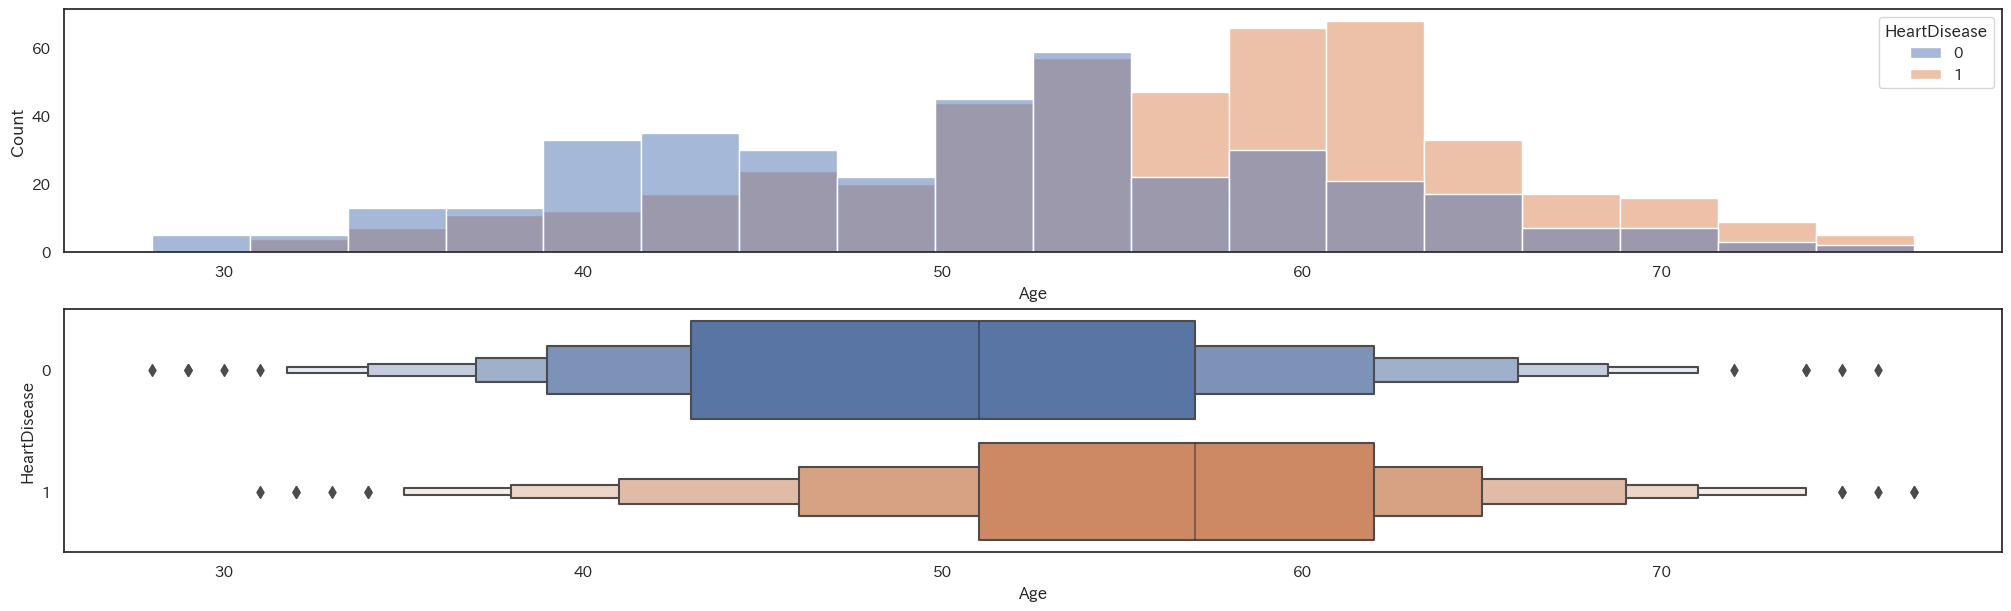

In [5]:
# Age

fig, (ax1, ax2) = plt.subplots(2, 1,figsize=(20, 6), layout='constrained')
sns.histplot(data=df, x='Age', hue='HeartDisease', ax=ax1)
sns.boxenplot(data=df, y='HeartDisease', x='Age', orient='h', ax=ax2)

# 高齢ほど陽性の傾向が明らか

,sum,count,mean
Sex,,,
F,47,177,0.266
M,410,649,0.632


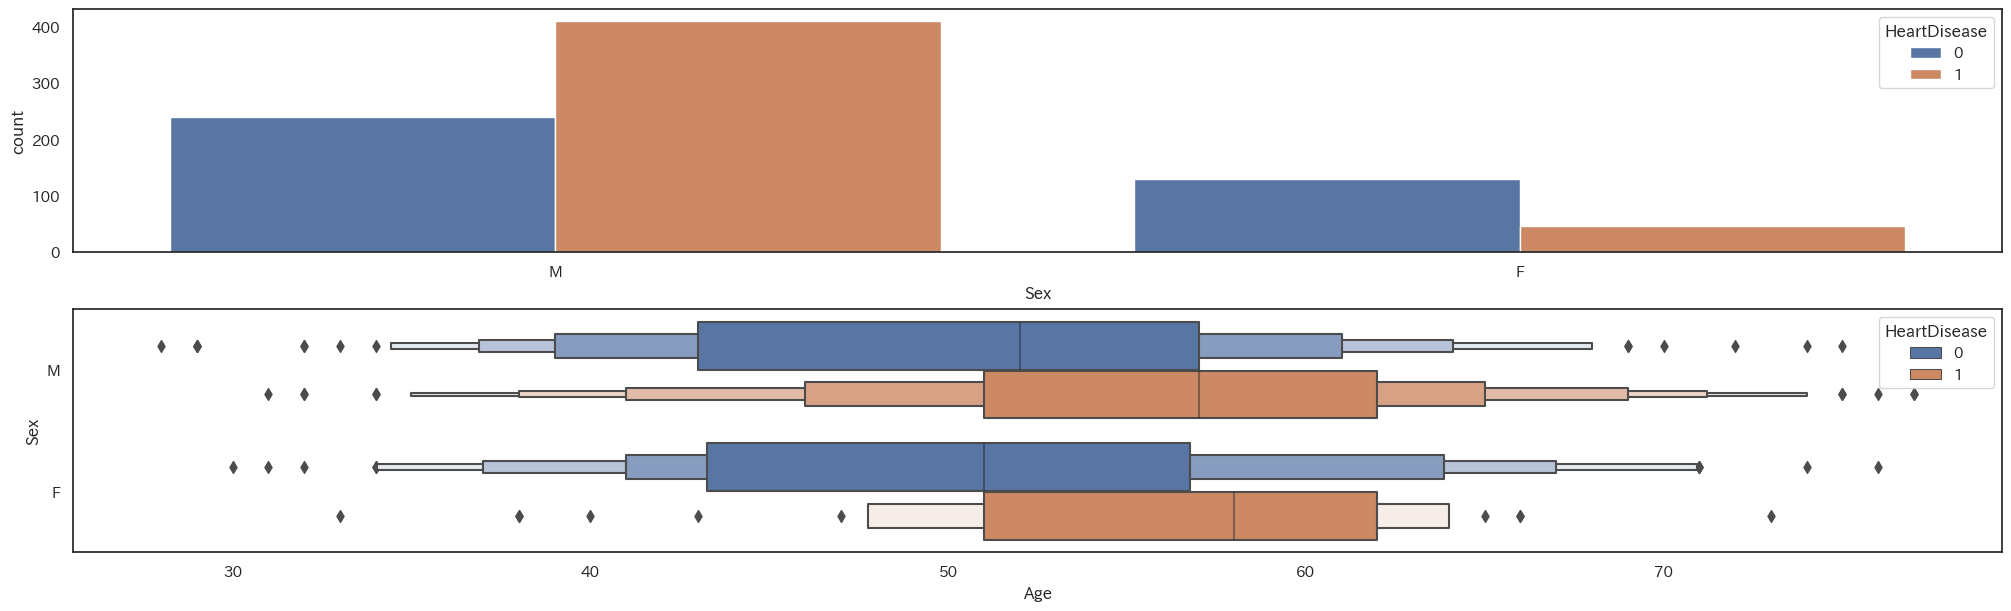

In [6]:
# Sex

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(20, 6), layout='constrained')
sns.countplot(data=df, x='Sex', hue='HeartDisease', ax=ax1)
sns.boxenplot(data=df, x='Age', y='Sex', hue='HeartDisease', orient='h', ax=ax2)

df.groupby('Sex')['HeartDisease'].agg(['sum', 'count', 'mean'])

# サンプル数に差があるが、男性の陽性率が女性の2倍以上
# そもそも男性に多い病気で、実際の差はもっと大きいのかもしれない
# 女性が更年期を迎えるとホルモンバランスの変化によりリスクが増加するため中高年以降はその差が縮まると言われている
# 性別年齢別に見ると、女性の方が中央値の年齢差が若干大きい

ChestPainType,ASY,ATA,NAP,TA
sum,353.000,19.000,67.000,18.000
count,442.000,154.000,188.000,42.000
mean,0.799,0.123,0.356,0.429


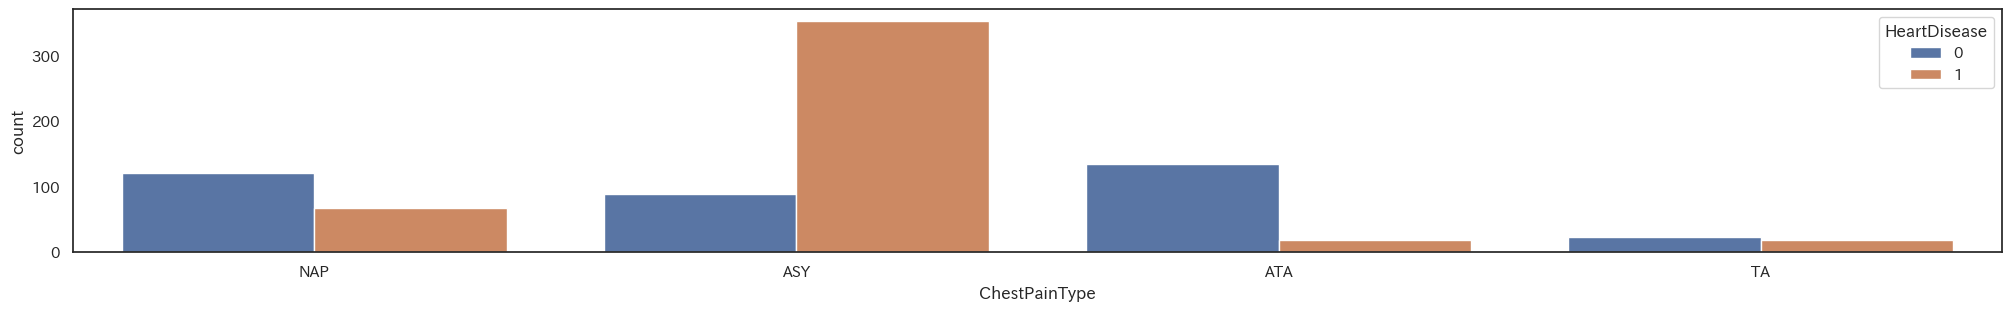

In [7]:
# ChestPainType

fig, ax = plt.subplots(figsize=(20, 3), layout='constrained')
sns.countplot(data=df, x='ChestPainType', hue='HeartDisease', ax=ax)
df.groupby('ChestPainType')['HeartDisease'].agg(['sum', 'count', 'mean']).T

# 胸痛との関係はASY(無症状)が8割なので、有病者でもなんらかの胸痛を伴うケースは2割程度ということ
# 且つ、NAP（非狭心症性疼痛）がTA（典型的狭心症）と大差ない比率
# このデータセットとしては有意な特徴量ながら汎用的とはいえない（サンプルに依存している）

RestingBP_10s,"(75, 85]","(85, 95]","(95, 105]","(105, 115]","(115, 125]","(125, 135]","(135, 145]","(145, 155]","(155, 165]","(165, 175]","(175, 185]","(185, 195]"
HeartDisease,0.0,0.875,0.469,0.576,0.462,0.511,0.608,0.545,0.685,0.765,0.643,0.5


RestingBP,80.0,92.0,94.0,95.0,96.0,100.0,101.0,102.0,104.0,105.0,...,165.0,170.0,172.0,174.0,178.0,180.0,185.0,190.0,192.0,200.0
HeartDisease,0.0,1.0,0.0,1.0,1.0,0.467,0.0,0.333,0.333,0.556,...,1.0,0.786,0.5,1.0,1.0,0.545,1.0,0.0,1.0,1.0


,ID,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease,MaxHR
318,449,55,M,NAP,NaN,0,0,Normal,N,1.5,Flat,1,155.0


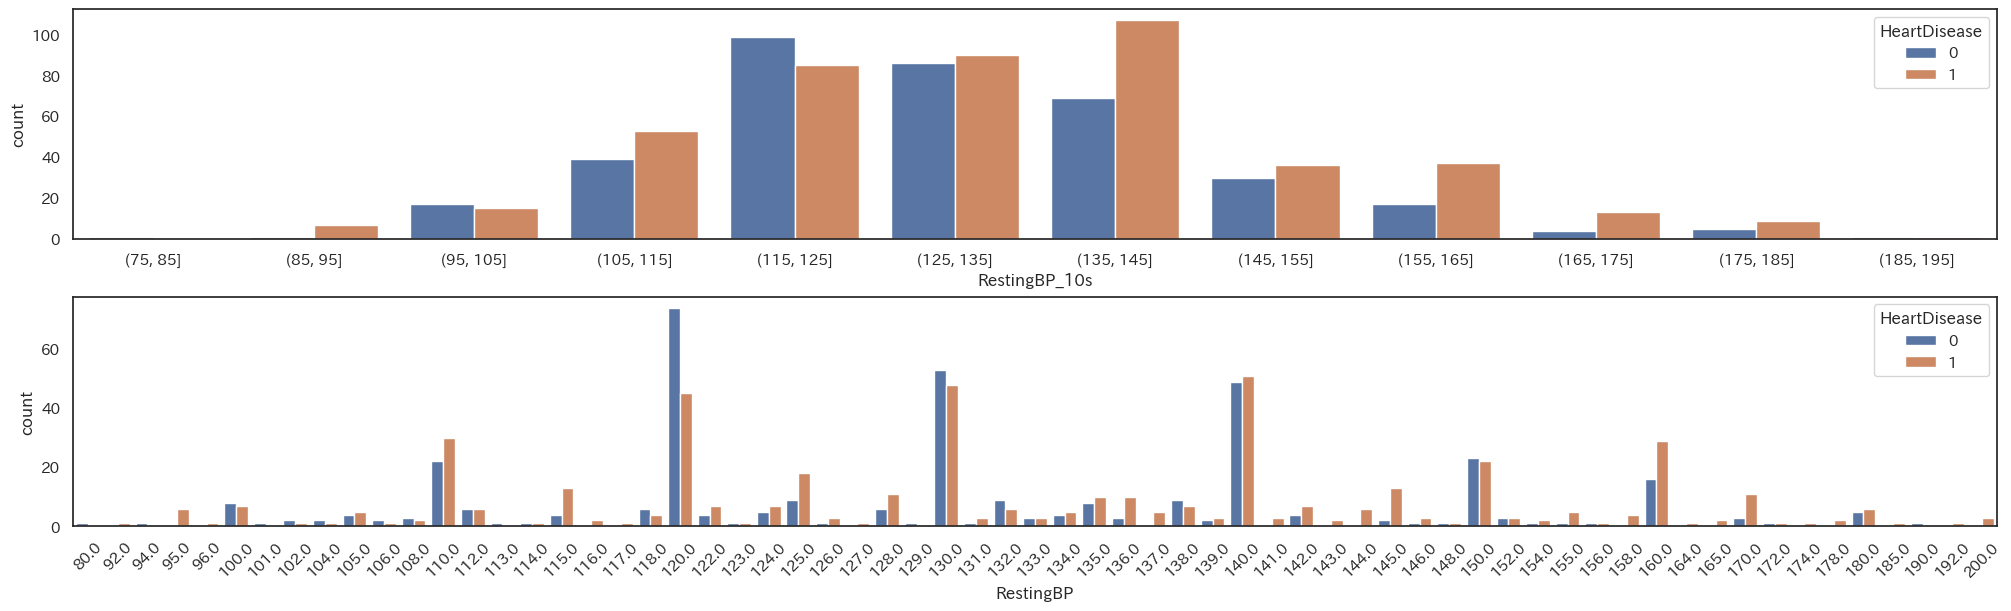

In [8]:
# RestingBP

df['RestingBP_10s'] = pd.cut(df['RestingBP'], range(75, 200, 10))
display(df.groupby(['RestingBP_10s'])[['HeartDisease']].mean().T)

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(20, 6), layout='constrained')
sns.countplot(data=df, x='RestingBP_10s', hue='HeartDisease', ax=ax1)
sns.countplot(data=df, x='RestingBP', hue='HeartDisease', ax=ax2)
ax2.tick_params(axis='x', rotation=45)
df = df.drop(['RestingBP_10s'], axis=1)

display(df.groupby(['RestingBP'])[['HeartDisease']].mean().T)
df[df['RestingBP'].isnull()]

# 安静時血圧が高過ぎても低すぎても心臓病罹患率が高い
# 10単位や5単位などきりの良い数字にデータが集中している
# 欠損値は1件だけで陽性要件の多いデータなので削除もしくは中央値を充てても問題なさそう

<Axes: xlabel='Cholesterol', ylabel='Count'>

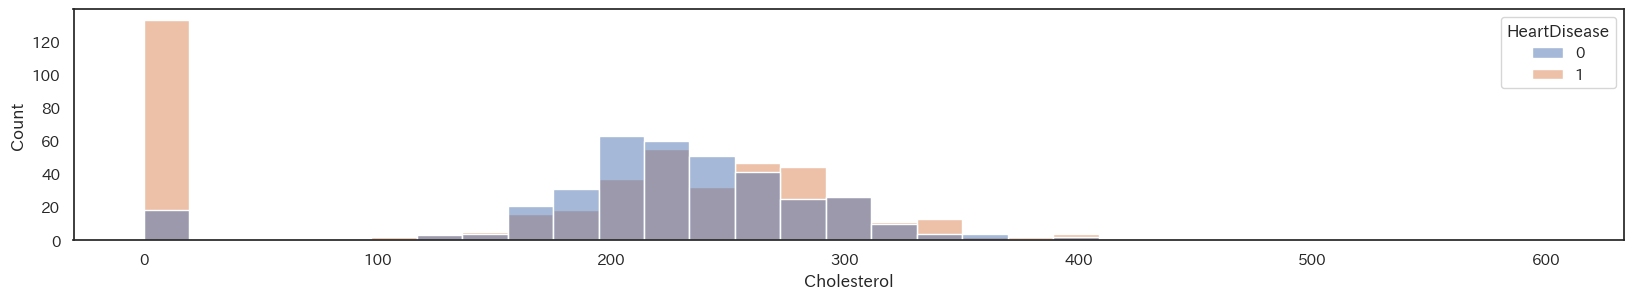

In [9]:
# Cholesterol

fig, ax = plt.subplots(figsize=(20, 3))
sns.histplot(data=df, x='Cholesterol', hue='HeartDisease', ax=ax)


# Cholesterol 0は現実的ではない（欠損のようなもの？）
# しかも罹患率88.1%は非常に高く、且つ、testデータにも21/92個（22.8%）も入っている
# 別特徴量としてフラグを立てた上で予測で補完することとするが、これも汎用的な特徴量ではない
# 全体的には高い数値の罹患率が高い

FastingBS,0,1
sum,302.00,155.000
count,629.00,197.000
mean,0.48,0.787


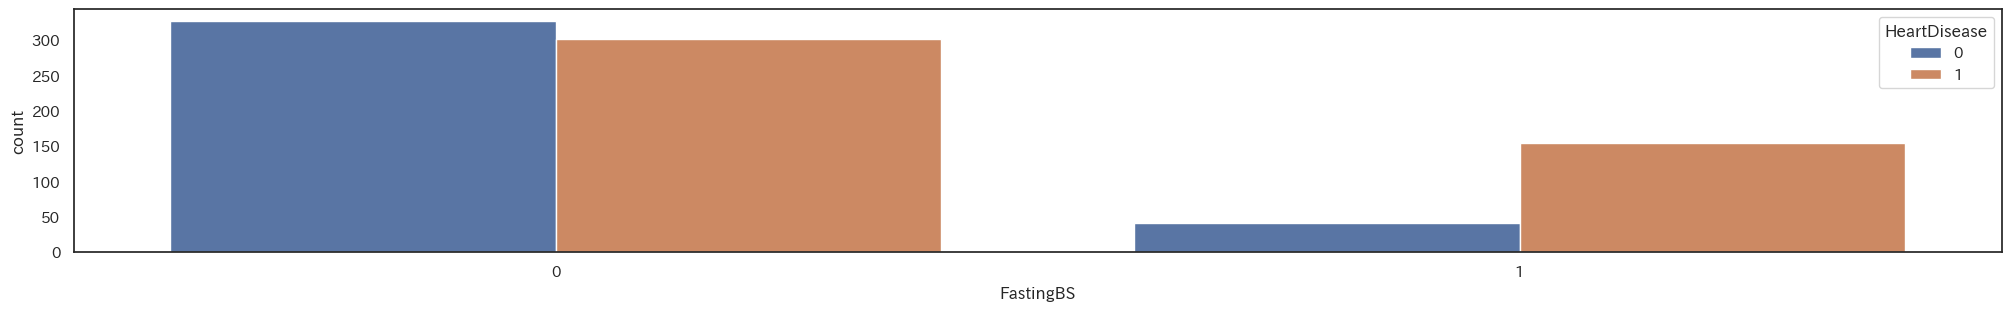

In [10]:
# FastingBS

fig, ax = plt.subplots(figsize=(20, 3), layout='constrained')
sns.countplot(data=df, x='FastingBS', hue='HeartDisease', ax=ax)
display(df.groupby('FastingBS')['HeartDisease'].agg(['sum', 'count', 'mean']).T)

# 空腹時血糖値が閾値120mg/dlを超えると罹患率が高い

,sum,count,mean
RestingECG,,,
LVH,94,171,0.550
Normal,255,493,0.517
ST,108,162,0.667


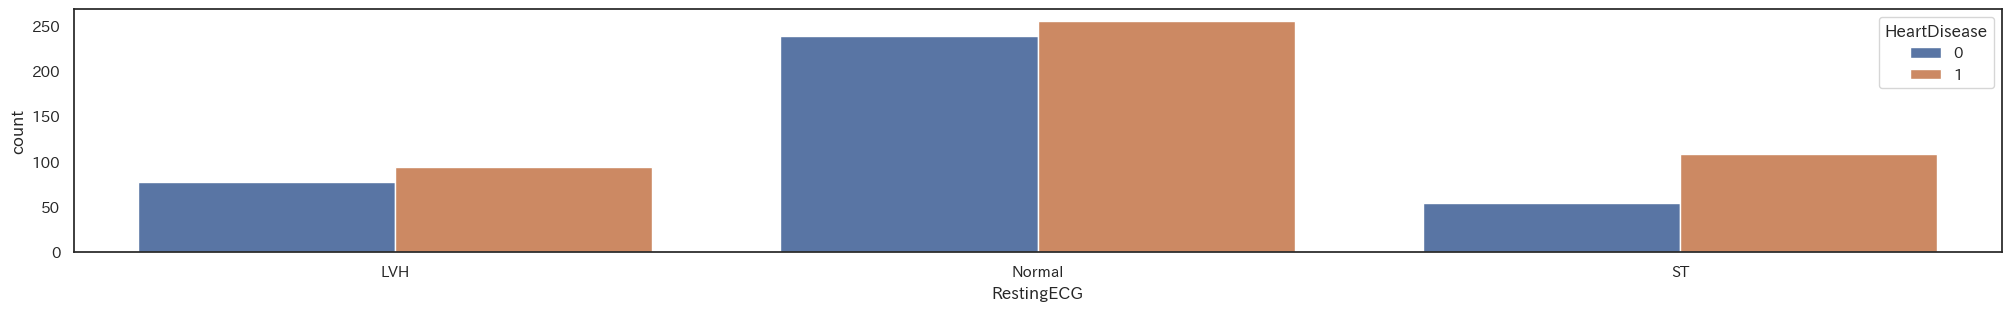

In [11]:
# RestingECG

fig, ax = plt.subplots(figsize=(20, 3), layout='constrained')
sns.countplot(data=df, x='RestingECG', hue='HeartDisease', ax=ax)

display(df.groupby('RestingECG')['HeartDisease'].agg(['sum', 'count', 'mean']))

# 安静時心電図、ST-T波異常の心臓病罹患率がやや高い

HeartDisease             
                        sum count   mean
ExerciseAngina                          
N                       176   494  0.356
Y                       281   332  0.846

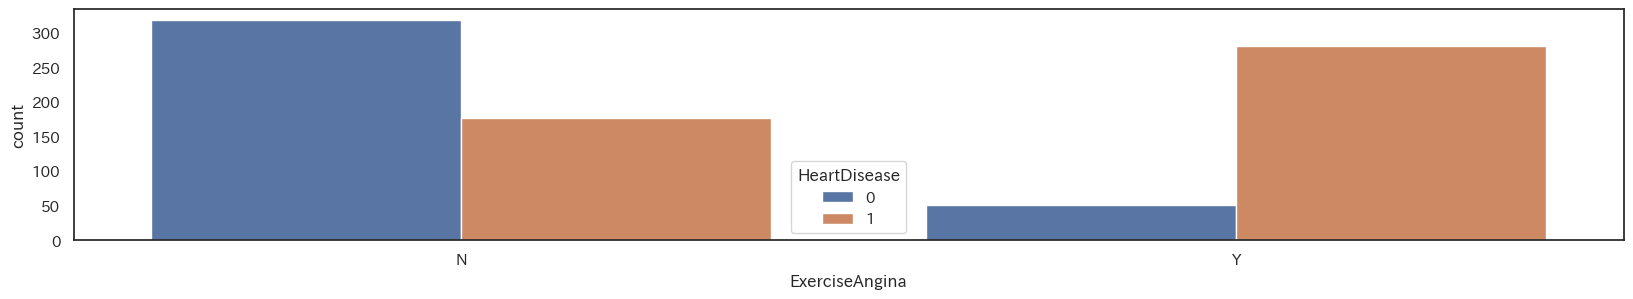

In [12]:
# ExerciseAngina

fig, ax = plt.subplots(figsize=(20, 3))
sns.countplot(data=df, x='ExerciseAngina', hue='HeartDisease', ax=ax)
display(df.groupby('ExerciseAngina')[['HeartDisease']].agg(['sum', 'count', 'mean']))

# 運動誘発性狭心症,Yesの罹患率が高いというのはこれは心臓病の一種なので当然と思われる
# Yesなのに心臓病でない意味は不明

<Axes: xlabel='Oldpeak', ylabel='Count'>

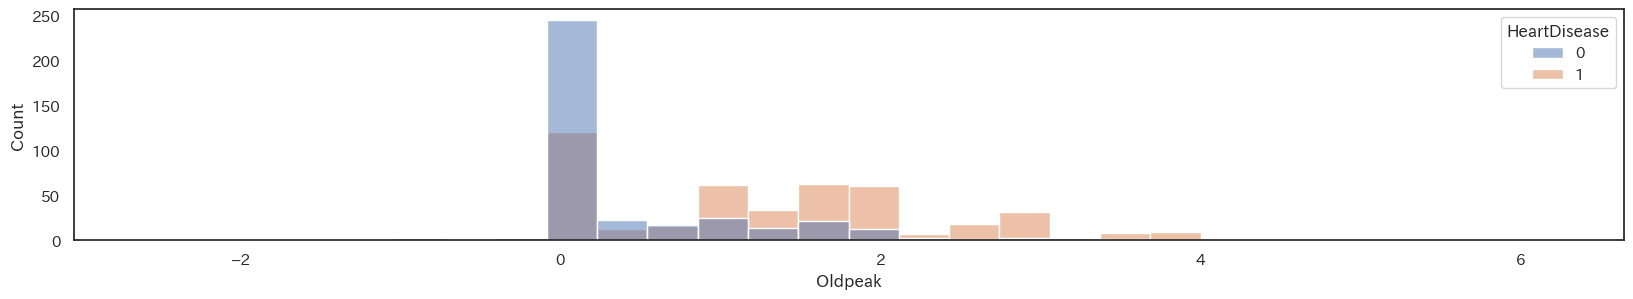

In [13]:
# Oldpeak

fig, ax = plt.subplots(figsize=(20, 3))
sns.histplot(data=df, x='Oldpeak', hue='HeartDisease', ax=ax)


# 安静時と比較したST低下とあるが、数値にプラスとマイナスがありどちらも罹患率が高い
# ST低下ってのが基本的にやばい、血流が減少する狭心症なんかでみられる現象
# グラフだとゼロかプラスに見えるがマイナスも大事では？


,sum,count,mean
ST_Slope,,,
Down,45,57,0.789
Flat,342,411,0.832
Up,70,358,0.196


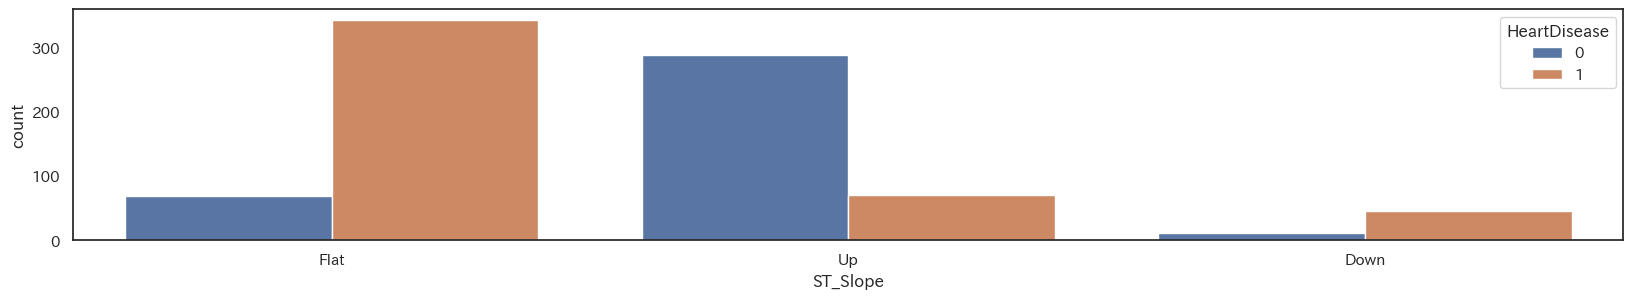

In [14]:
# ST_Slope

fig, ax = plt.subplots(figsize=(20, 3))
sns.countplot(data=df, x='ST_Slope', hue='HeartDisease', ax=ax)

df.groupby('ST_Slope')['HeartDisease'].agg(['sum', 'count', 'mean'])

# 運動時STピークの傾き、FlatとDownの罹患率が高い


,HeartDisease
sum,364.00
count,400.00
mean,0.91


,HeartDisease
sum,9.000
count,132.000
mean,0.068


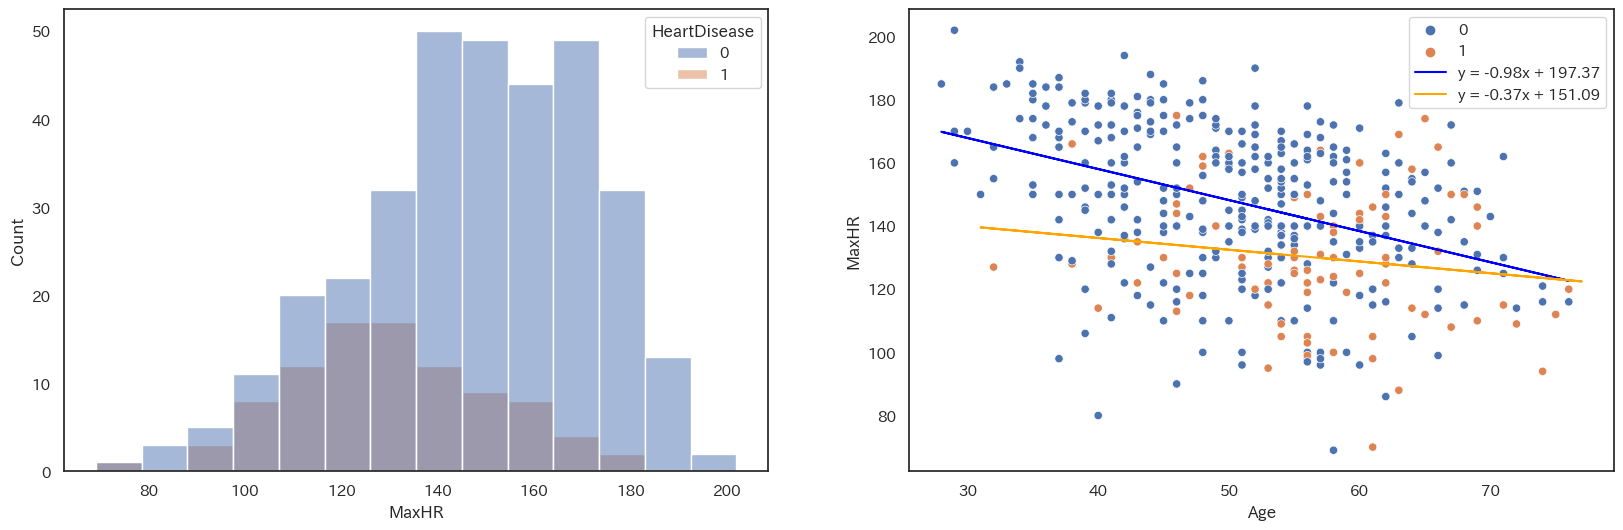

In [15]:
# MaxHR

display(df[df['MaxHR'].isnull()][['HeartDisease']].agg(['sum', 'count', 'mean']))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 6))
sns.histplot(data=df, x='MaxHR', hue='HeartDisease', ax=ax1)
sns.scatterplot(data=df, y='MaxHR', x='Age', hue='HeartDisease', ax=ax2)

for hd, color in zip([0, 1], ['blue', 'orange']):
    x = df.loc[df['HeartDisease'] == hd, 'Age'].values
    y = df.loc[df['HeartDisease'] == hd, 'MaxHR'].values
    non_nan_idx = ~np.isnan(y)
    a, b = np.polyfit(x[non_nan_idx], y[non_nan_idx], 1)
    y_reg = a * x + b
    ax2.plot(x, y_reg, color=color, label=f'y = {a:.2f}x + {b:.2f}')
    ax2.legend()

display(df[(df['Age']<50)&(df['MaxHR']>130)][['HeartDisease']].agg(['sum', 'count', 'mean']))

# MaxHR(最高心拍数)が低い方が有病率が高い
# 年齢が上がるとMaxHRは下がるが有病者の低下傾向は緩やか
# つまり高齢になるほどMaxHRの水準と有病率に差がなくなる
# 欠損値の罹患率がこれまた非常に高いので特徴量として抽出し値は中央値で補完


## 特徴量エンジニアリング（含む前処理）

In [16]:
df.columns, df_test.columns

(Index(['ID', 'Age', 'Sex', 'ChestPainType', 'RestingBP', 'Cholesterol',
        'FastingBS', 'RestingECG', 'ExerciseAngina', 'Oldpeak', 'ST_Slope',
        'HeartDisease', 'MaxHR'],
       dtype='object'),
 Index(['ID', 'Age', 'Sex', 'ChestPainType', 'RestingBP', 'Cholesterol',
        'FastingBS', 'RestingECG', 'ExerciseAngina', 'Oldpeak', 'ST_Slope',
        'MaxHR'],
       dtype='object'))

In [17]:
# 特徴量作成(欠損情報)

df['MaxHR_missing'] = df['MaxHR'].isnull().astype(int)
df['Chol_zero'] = (df['Cholesterol'] == 0).astype(int)
df_test['MaxHR_missing'] = df_test['MaxHR'].isnull().astype(int)
df_test['Chol_zero'] = (df_test['Cholesterol'] == 0).astype(int)

display(df.groupby('MaxHR_missing')['HeartDisease'].agg(['sum', 'count', 'mean']))
display(df.groupby('Chol_zero')['HeartDisease'].agg(['sum', 'count', 'mean']))

# 欠損値の置換、補完

df['Cholesterol'].replace(0, np.nan, inplace=True)
df['RestingBP'].fillna(df['RestingBP'].median(), inplace=True)
df['MaxHR'].fillna(df['MaxHR'].median(), inplace=True)
df['Cholesterol'].fillna(df['Cholesterol'].median(), inplace=True)
df_test['Cholesterol'].replace(0, np.nan, inplace=True)
df_test['RestingBP'].fillna(df_test['RestingBP'].median(), inplace=True)
df_test['MaxHR'].fillna(df_test['MaxHR'].median(), inplace=True)
df_test['Cholesterol'].fillna(df_test['Cholesterol'].median(), inplace=True)


# その他の特徴量作成　D2/3

display(df.groupby(['Chol_zero', 'FastingBS', 'MaxHR_missing'])['HeartDisease'].agg(['sum', 'count', 'mean']))
df['D2/3'] = df.apply(lambda x: 1 if (x['Chol_zero'] + x['FastingBS'] + x['MaxHR_missing'])>=2 else 0, axis=1)
df_test['D2/3'] = df_test.apply(lambda x: 1 if (x['Chol_zero'] + x['FastingBS'] + x['MaxHR_missing'])>=2 else 0, axis=1)
display(df.groupby('D2/3')['HeartDisease'].agg(['sum', 'count', 'mean']))

# 有病率が高い特徴量を組み合わせたものを追加

# カテゴリカル変数のOne-Hotエンコーディング
df_encoded = pd.get_dummies(df.drop('ID', axis=1), drop_first=True)
df_test_encoded = pd.get_dummies(df_test.drop('ID', axis=1), drop_first=True)

# ChatGPTのコードはいつもやっているコーディング手法といろいろ違うところがありとても勉強になる

,sum,count,mean
MaxHR_missing,,,
0,93,426,0.218
1,364,400,0.910


,sum,count,mean
Chol_zero,,,
0,324,675,0.480
1,133,151,0.881


sum  count   mean
Chol_zero FastingBS MaxHR_missing                   
0         0         0               52    333  0.156
                    1              196    225  0.871
          1         0               17     52  0.327
                    1               59     65  0.908
1         0         0               10     26  0.385
                    1               44     45  0.978
          1         0               14     15  0.933
                    1               65     65  1.000

,sum,count,mean
D2/3,,,
0,275,636,0.432
1,182,190,0.958


In [18]:
df_encoded

,Age,RestingBP,Cholesterol,FastingBS,Oldpeak,HeartDisease,MaxHR,MaxHR_missing,Chol_zero,D2/3,Sex_M,ChestPainType_ATA,ChestPainType_NAP,ChestPainType_TA,RestingECG_Normal,RestingECG_ST,ExerciseAngina_Y,ST_Slope_Flat,ST_Slope_Up
0,57,128.0,229.0,0,0.4,1,144.0,1,0,0,1,0,1,0,0,0,0,1,0
1,65,150.0,225.0,0,1.0,1,144.0,1,0,0,0,0,0,0,0,0,0,1,0
2,72,160.0,123.0,1,1.5,1,144.0,1,0,1,1,0,0,0,0,0,0,1,0
3,46,134.0,310.0,0,0.0,1,144.0,1,0,0,1,0,0,0,1,0,0,1,0
4,56,120.0,236.0,0,0.8,0,178.0,0,0,0,1,1,0,0,1,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
821,62,124.0,209.0,0,0.0,0,163.0,0,0,0,0,0,0,0,1,0,0,0,1
822,59,174.0,249.0,0,0.0,1,144.0,1,0,0,0,0,0,0,1,0,1,1,0
823,53,124.0,260.0,0,3.0,0,144.0,1,0,0,1,0,0,0,0,1,1,1,0
824,63,150.0,407.0,0,4.0,1,144.0,1,0,0,0,0,0,0,0,0,0,1,0


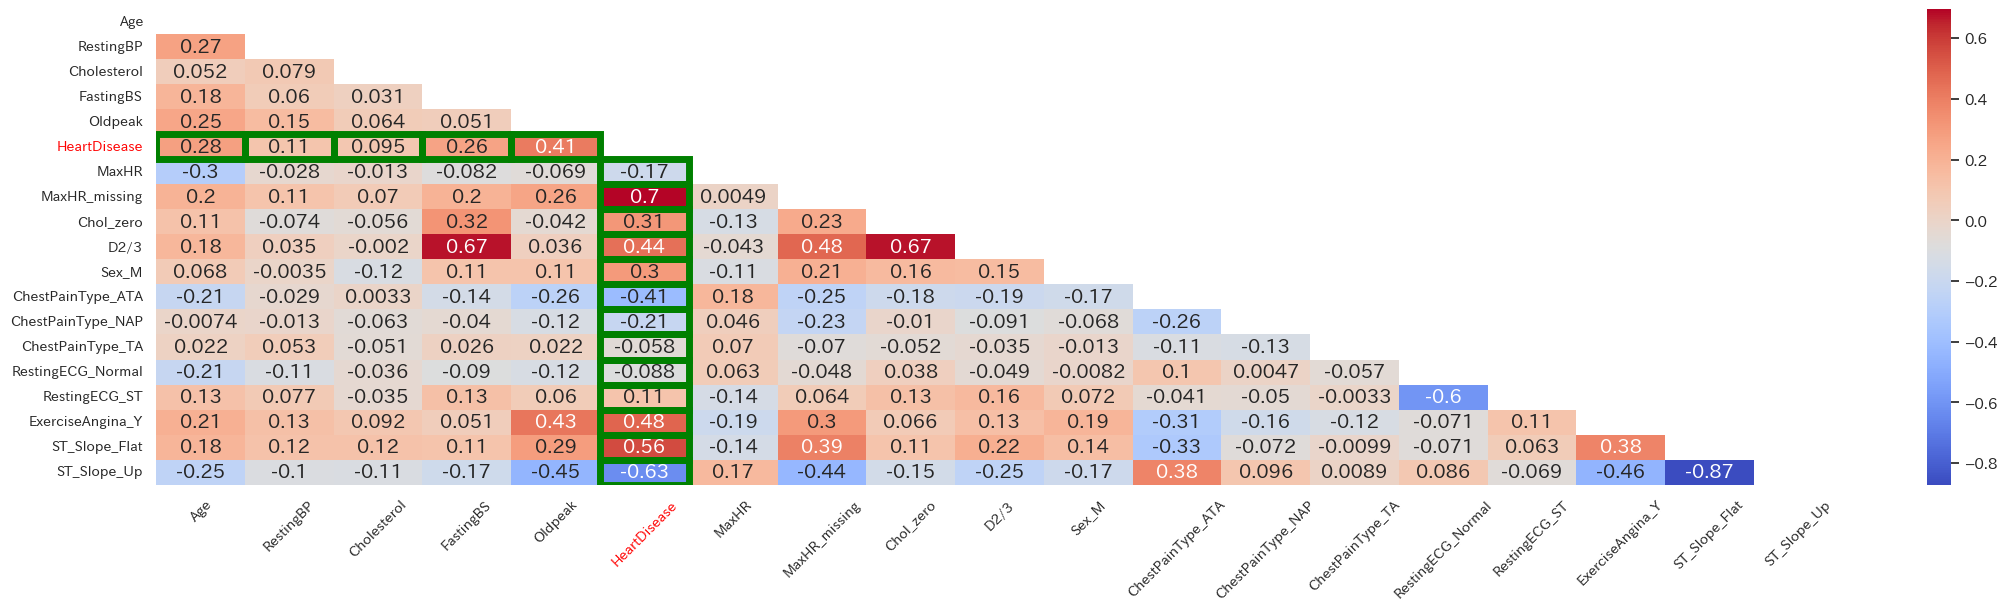

In [19]:
# ヒートマップ,相関係数
corr = df_encoded.corr()
fig, ax = plt.subplots(figsize=(20, 6), layout='constrained')
mask = np.triu(np.ones_like(corr))
sns.heatmap(corr, mask=mask, annot=True, cmap='coolwarm', annot_kws={'size':14})
ax.tick_params(axis='x', labelsize=10, rotation=45)
ax.tick_params(axis='y', labelsize=10)

# 目的変数の枠線の追加
index = list(corr.columns).index('HeartDisease')
for i in range(len(corr.columns)):
    if i > index:
        plt.gca().add_patch(plt.Rectangle((index, i), 1, 1,
                                          fill=False, edgecolor='green', lw=5))
    elif i < index:
        plt.gca().add_patch(plt.Rectangle((i, index), 1, 1,
                                          fill=False, edgecolor='green', lw=5))

# 目的変数の強調
for i, label in enumerate(ax.get_xticklabels()):
    if label.get_text() == 'HeartDisease':
        label.set_color('red')
        label.set_fontweight('bold')
for i, label in enumerate(ax.get_yticklabels()):
    if label.get_text() == 'HeartDisease':
        label.set_color('red')
        label.set_fontweight('bold')
plt.show()

# ST_Slope_UpとST_Slope_Flatは相関が高すぎるのでST_Slope_Flatを削除

In [20]:
# 特徴量と目的変数の分割
# ST_Slope_UpとST_Slope_Flatは相関が高すぎるのでST_Slope_Flatを削除
X = df_encoded.drop(['HeartDisease', 'ST_Slope_Flat'], axis=1)
y = df_encoded['HeartDisease']
X_test = df_test_encoded.drop('ST_Slope_Flat', axis=1)

# 特徴量のスケーリング
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_test_scaled = scaler.fit_transform(X_test)

In [21]:
# 予測と評価

# 5分割のStratifiedKFoldを使用
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

auc_scores = []
accuracy_scores = []
probs = np.zeros(X_scaled.shape[0])
preds = np.zeros(X_scaled.shape[0])

# 5分割クロスバリデーションでのモデルの訓練と評価
for train_index, test_index in skf.split(X_scaled, y):
    X_train_fold, X_test_fold = X_scaled[train_index], X_scaled[test_index]
    y_train_fold, y_test_fold = y.iloc[train_index], y.iloc[test_index]
    
    logreg = LogisticRegression()
    logreg.fit(X_train_fold, y_train_fold)
    
    y_prob_fold = logreg.predict_proba(X_test_fold)[:, 1]
    y_pred_fold = logreg.predict(X_test_fold)
    
# テストデータの予測結果を保存
    probs[test_index] = y_prob_fold
    preds[test_index] = y_pred_fold
    
# auc_score、accuracy_scoreを保存
    auc_scores.append(roc_auc_score(y_test_fold, y_prob_fold))
    accuracy_scores.append(accuracy_score(y_test_fold, y_pred_fold))

print(f'AUC_conv      : {roc_auc_score(y, probs)}')
print(f'Accuracy_conv : {accuracy_score(y, preds)}')

print(f'AUC_avg       : {sum(auc_scores) / len(auc_scores)}')
print(f'Accuracy_avg  : {sum(accuracy_scores) / len(accuracy_scores)}')

# クロスバリデーション結果を合成して訓練データ全体の評価を表示
# これでも十分なスコアだが、ここからモデルとしてのブラッシュアップを行う

AUC_conv      : 0.9672424733000066
Accuracy_conv : 0.8946731234866828
AUC_avg       : 0.9674865248718734
Accuracy_avg  : 0.8946184738955824


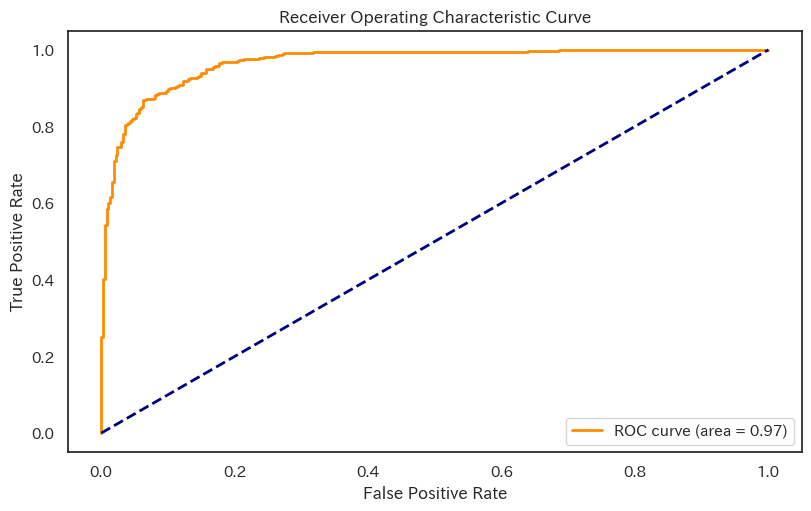

In [22]:
# AUC曲線

fpr, tpr, thresholds = roc_curve(y, probs)
roc_auc = auc(fpr, tpr)

fig, ax = plt.subplots(figsize=(8, 5), layout='constrained')

ax.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
ax.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('Receiver Operating Characteristic Curve')
ax.legend(loc='lower right')

# 取り敢えずAUC曲線、美しい

<Axes: ylabel='Count'>

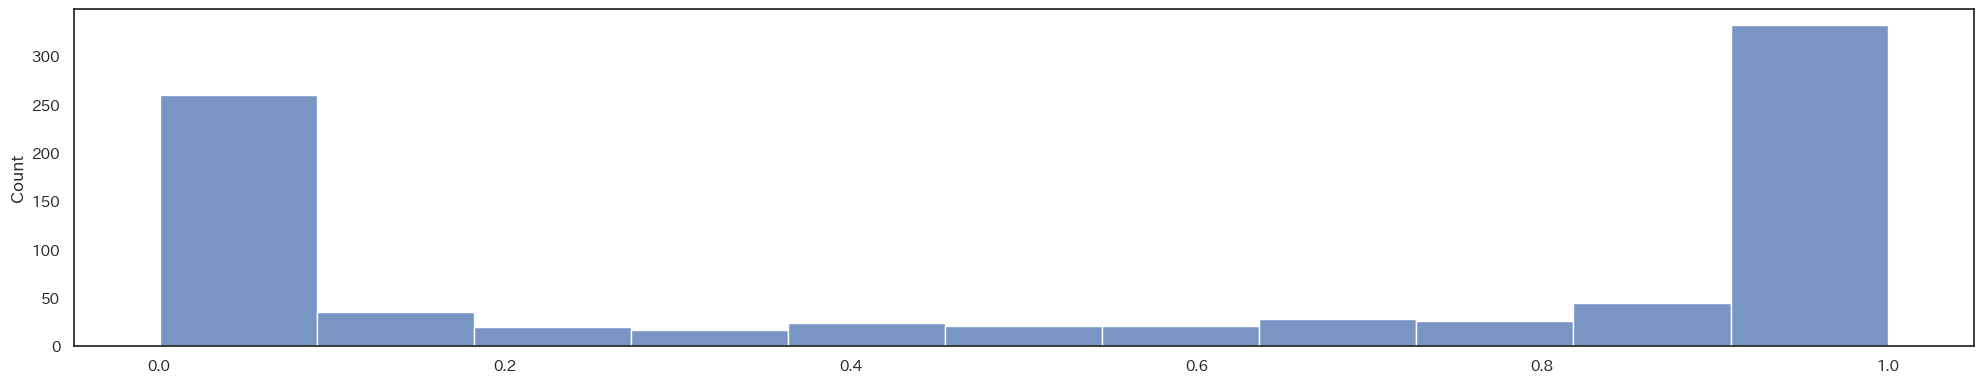

In [23]:
# 予測の分布状況

fig, ax = plt.subplots(figsize=(20, 4), tight_layout=True)
sns.histplot(probs)

# 凡そ0、1に予測出来ているが、中間のものもそれなりにある

Text(325.75, 0.5, 'Pred label')

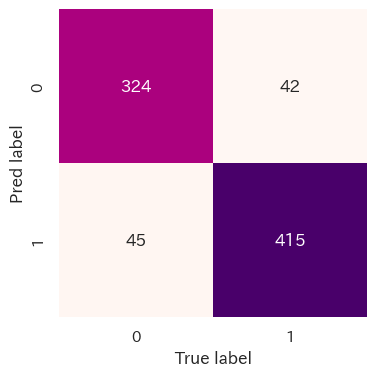

In [24]:
# 混合行列
fig, ax = plt.subplots(figsize=(10, 4))
mat = confusion_matrix(y, preds)
sns.heatmap(mat.T, square=True, annot=True, fmt='d',
        cmap='RdPu', cbar=False, ax=ax)
ax.set_xlabel('True label')
ax.set_ylabel('Pred label')

# 真陽性、偽陽性、真陰性、偽陰性の各々の数字も確認
# 1割ちょっと間違っており、だからAccuracyは0.9止まり

Text(0.5, 1.0, 'Feature Importance (Logistic Regression Coefficients)')

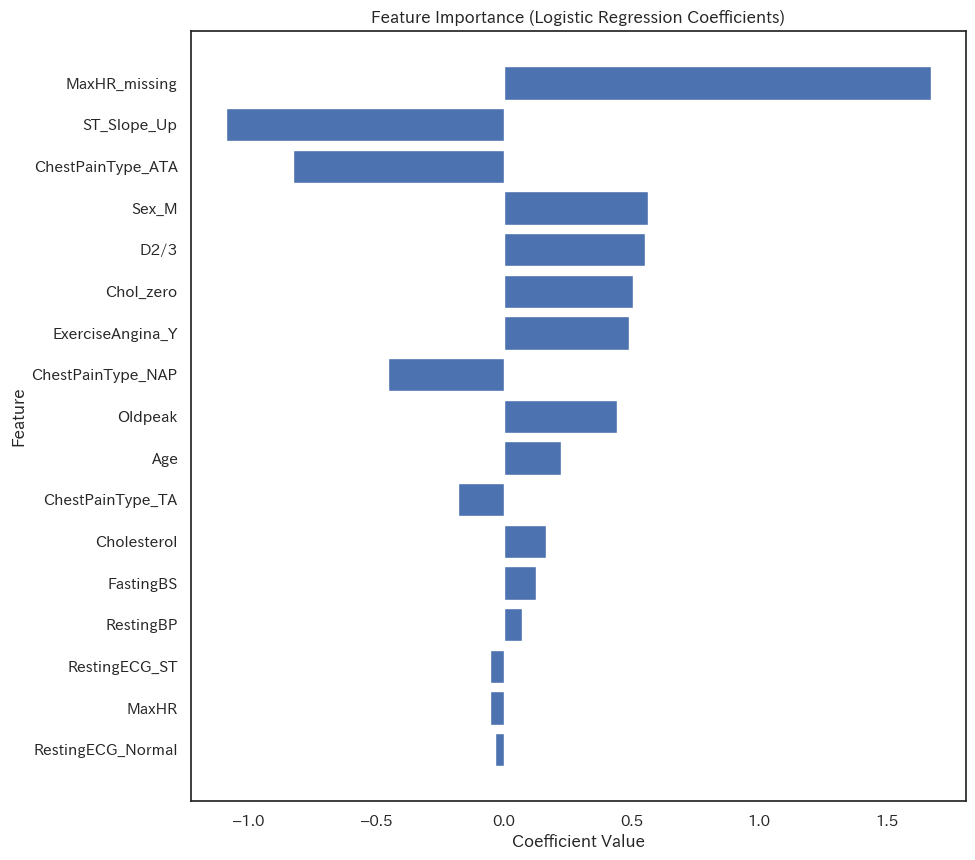

In [25]:
# 全データを使用してロジスティック回帰モデルを再訓練
logreg_full = LogisticRegression()
logreg_full.fit(X_scaled, y)

# 係数を取得
coefficients = logreg_full.coef_[0]

# 係数の絶対値を取得して影響度を可視化
plt.figure(figsize=(10, 10))
sorted_idx = np.argsort(np.abs(coefficients))
plt.barh(X.columns[sorted_idx], coefficients[sorted_idx])
plt.xlabel("Coefficient Value")
plt.ylabel("Feature")
plt.title("Feature Importance (Logistic Regression Coefficients)")

# 特徴量重要度を確認

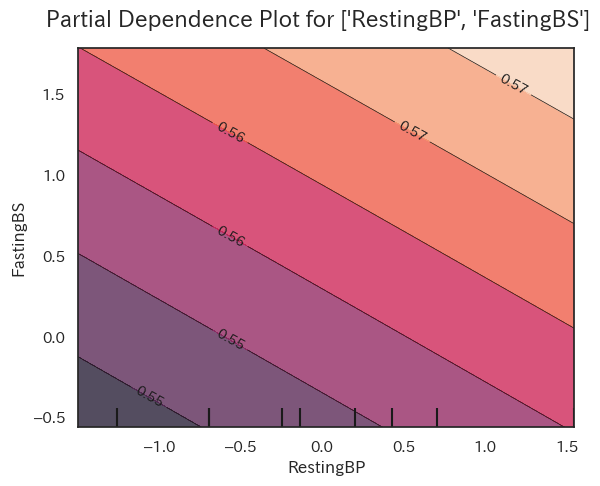

In [26]:
# 部分依存プロット（PDP）による特徴量相互作用の確認

from sklearn.inspection import PartialDependenceDisplay

# 特徴量の名前とインデックスを再定義
feature_names_2d_maxhr = ['RestingBP', 'FastingBS']
feature_indices_2d_maxhr = [X.columns.get_loc(name) for name in feature_names_2d_maxhr]

# 部分依存プロットの再作成
display = PartialDependenceDisplay.from_estimator(
    logreg_full, X_scaled, [feature_indices_2d_maxhr], feature_names=X.columns, grid_resolution=50
)

plt.suptitle(f"Partial Dependence Plot for {feature_names_2d_maxhr}", fontsize=16)
plt.subplots_adjust(top=0.9)

# 各特徴量の相互作用を確認
# ひとつずつでもプロットできるがここでは相互作用をシミュレートする
# 例えばこの例であれば、RestingBPとFastingBSがともに大きいほど陽性確率は上がるが、それは0.55→0.57に止まるということ

,0,1,2,3,4,5,6,7,8,9
Training samples,66,132,198,264,330,396,462,528,594,660
Training score,0.975,0.970,0.969,0.968,0.970,0.969,0.970,0.971,0.971,0.971
Validation score,0.958,0.966,0.968,0.966,0.969,0.969,0.969,0.969,0.970,0.970


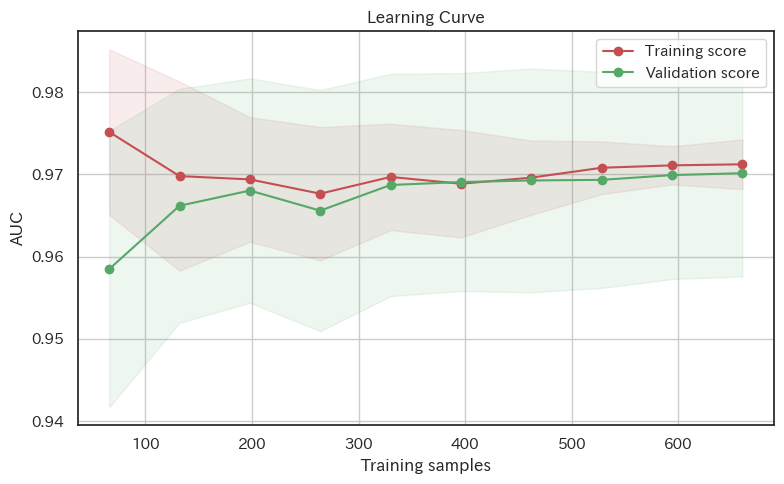

In [27]:
# 学習曲線による特徴量選択

from metric_plotter import MetricPlotter
title = 'Learning Curve'
cv = 5
estimator = LogisticRegression()

df_scaled = pd.DataFrame(X_scaled, columns=X.columns)
df_test_scaled = pd.DataFrame(X_test_scaled, columns=X.columns)

features = [
#        'Age',
#        'RestingBP',
#        'Cholesterol',
#        'FastingBS',
#        'Oldpeak',
#        'MaxHR',
        'MaxHR_missing',
        'Chol_zero',
        'D2/3',
        'Sex_M',
        'ChestPainType_ATA',
        'ChestPainType_NAP',
#        'ChestPainType_TA',
#        'RestingECG_Normal',
#        'RestingECG_ST',
        'ExerciseAngina_Y',
        'ST_Slope_Up',
]

plotter = MetricPlotter(estimator=estimator, title=title, metric='auc')
_ = plotter.plot_learning_curve(df_scaled[features], y, cv=cv)

# 先週作成した学習曲線描画ツール
# シミュレートしながらTraining scoreとValidation scoreの差が小さく且つValidation scoreの値が大きいところを探す

In [28]:
# NNモデルアンサンブル

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

# ニューラルネットワークのモデルを定義
NN_model = Sequential()
# 入力層
NN_model.add(Dense(64, activation='relu', input_shape=(df_scaled[features].shape[1],)))  # Dense層（全結合層）を追加
NN_model.add(Dropout(0.2))
# 隠れ層
NN_model.add(Dense(32, activation='relu'))
NN_model.add(Dropout(0.2))
NN_model.add(Dense(16, activation='relu'))
NN_model.add(Dropout(0.2))
# 出力層
NN_model.add(Dense(1, activation='sigmoid'))

# モデルをコンパイル: 最適化アルゴリズムにはAdamを、損失関数にはbinary_crossentropyを使用
NN_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[tf.keras.metrics.AUC()])

# モデルを訓練: エポック数は50、バッチサイズは32、バリデーションの割合は20%に設定
NN_model.fit(df_scaled[features], y, epochs=50, batch_size=32, validation_split=0.2)

# 9月の応用課題のNNモデル（Sequential）で予測を実施
# 予測精度は高いが特徴量を詰め込むと過学習し易い

Epoch 1/50
21/21 [==============================] - 1s 14ms/step - loss: 0.6106 - auc: 0.7909 - val_loss: 0.5114 - val_auc: 0.9462
Epoch 2/50
21/21 [==============================] - 0s 4ms/step - loss: 0.4620 - auc: 0.9199 - val_loss: 0.3766 - val_auc: 0.9614
Epoch 3/50
21/21 [==============================] - 0s 4ms/step - loss: 0.3396 - auc: 0.9502 - val_loss: 0.2837 - val_auc: 0.9634
Epoch 4/50
21/21 [==============================] - 0s 4ms/step - loss: 0.2924 - auc: 0.9494 - val_loss: 0.2428 - val_auc: 0.9659
Epoch 5/50
21/21 [==============================] - 0s 4ms/step - loss: 0.2685 - auc: 0.9560 - val_loss: 0.2271 - val_auc: 0.9719
Epoch 6/50
21/21 [==============================] - 0s 4ms/step - loss: 0.2509 - auc: 0.9609 - val_loss: 0.2154 - val_auc: 0.9725
Epoch 7/50
21/21 [==============================] - 0s 4ms/step - loss: 0.2439 - auc: 0.9633 - val_loss: 0.2156 - val_auc: 0.9737
Epoch 8/50
21/21 [==============================] - 0s 4ms/step - loss: 0.2250 - auc: 0.9

In [29]:
from tensorflow.keras.models import Model

# 既存のNNモデルから、特定の隠れ層の出力を取得する新しいモデルを作成
intermediate_layer_model = Model(inputs=NN_model.input, outputs=NN_model.layers[-4].output)
# 訓練データで新しいモデルを実行して、新しい特徴量を取得
intermediate_output = intermediate_layer_model.predict(df_scaled[features])
intermediate_output_test = intermediate_layer_model.predict(df_test_scaled[features])
# 新しい特徴量をオリジナルのデータセットに追加
df_scaled_new_features = np.concatenate([df_scaled[features], intermediate_output], axis=1)
df_test_scaled_new_features = np.concatenate([df_test_scaled[features], intermediate_output_test], axis=1)

# NNモデルから最終隠れ層の出力を特徴量として抽出するやり方
# 元の特徴量と合算するところまで実施

3/3 [==============================] - 0s 3ms/step


,0,1,2,3,4,5,6,7,8,9
Training samples,66,132,198,264,330,396,462,528,594,660
Training score,0.987,0.987,0.984,0.983,0.982,0.979,0.979,0.978,0.978,0.977
Validation score,0.969,0.970,0.971,0.973,0.973,0.974,0.974,0.974,0.974,0.974


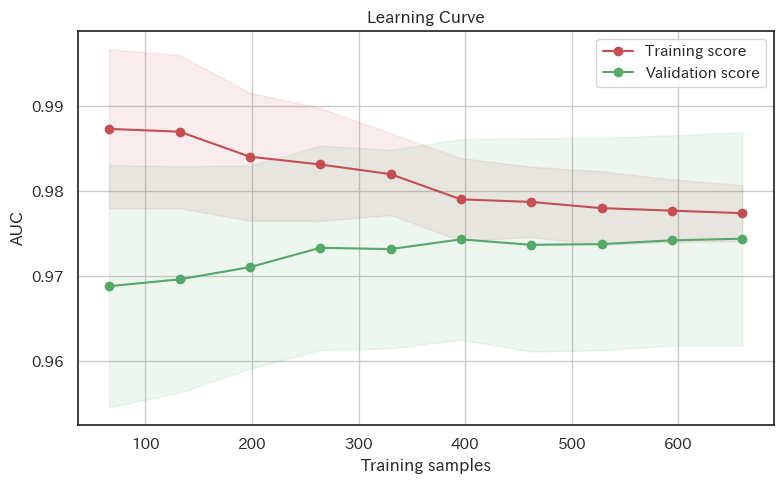

In [30]:
# アンサンブル効果の可視化

plotter = MetricPlotter(estimator=estimator, title=title, metric='auc')
_ = plotter.plot_learning_curve(df_scaled_new_features, y, cv=cv)

# Training scoreとValidation scoreがわずかに離れたが許容範囲
# スコアが改善していることを確認

In [31]:
# 提出データをLogistic回帰モデルで予測

LR_model = LogisticRegression()
LR_model.fit(df_scaled_new_features, y)
LR_pred = LR_model.predict_proba(df_test_scaled_new_features)[:, 1]

In [32]:
# 提出用データファイルのセッティング
df_submit = pd.read_csv('C:\\Users\\yuich\\KC_data\\heart_disease\\sample_submission.csv')
df_submit['HeartDisease'] = LR_pred
df_submit.set_index('ID', inplace=True)
df_submit.to_csv('submit.csv')

# 提出スコア　0.96 → 0.97 に改善した

  0%|          | 0/92 [00:00<?, ?it/s]

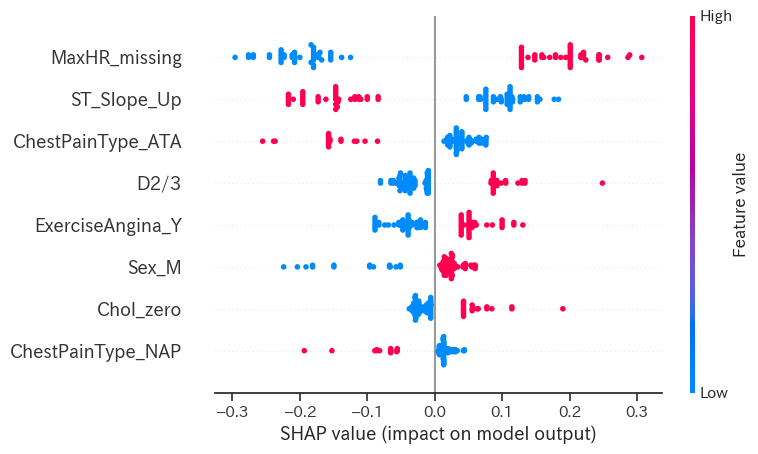

In [33]:
# SHAPによる特徴量重要度の可視化

import shap
explainer = shap.KernelExplainer(NN_model, df_test_scaled[features])
shap_values = explainer.shap_values(df_test_scaled[features])
shap.summary_plot(shap_values[0], df_test_scaled[features])

# 最後にSHAPの要約プロットも確認
# KernelExplainerが重いのでtestデータ（92個）で実施している
# 重要度の大きさもさることながら、赤と青の分離度合いを確認（混ざっているとノイズを過学習する）
# 他に重要度がそこそこ高い特徴量もあるが、赤青混じっているものを外したことでスコアは改善している